## Импорт библиотек

In [157]:
# Загрузка библиотек необходимых для отрисовки графиков
import matplotlib
import math as mt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp
%matplotlib inline
import pandas as pd
import json

## Считываем файл с исходными данными

In [158]:
class InvalidInputError(Exception):
    """Исключение для некорректных входных данных."""
    pass

input_file = input('Введите имя файла json без расширения, который лежит в той же папке, что и данный файл: ')
file = input_file + '.json'

try:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
except InvalidInputError as e:
    print ('Нет такого файла в папке')

data = pd.DataFrame([data])


## Расчетная часть

In [159]:
def calc_ws(
        gamma_wat: float
) -> float:
    """
    Функция для расчета солесодержания в воде

    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.

    :return: солесодержание в воде, г/г
    """
    ws = (
            1 / (gamma_wat * 1000)
            * (1.36545 * gamma_wat * 1000 - (3838.77 * gamma_wat * 1000 - 2.009 * (gamma_wat * 1000) ** 2) ** 0.5)
    )
    # если значение отрицательное, значит скорее всего плотность ниже допустимой 992 кг/м3
    if ws > 0:
        return ws
    else:
        return 0


def calc_rho_w(
        ws: float,
        t: float
) -> float:
    """
    Функция для расчета плотности воды в зависимости от температуры и солесодержания

    :param ws: солесодержание воды, г/г
    :param t: температура, К

    :return: плотность воды, кг/м3
    """
    rho_w = 1000 * (1.0009 - 0.7114 * ws + 0.2605 * ws ** 2) ** (-1)

    return rho_w / (1 + (t - 273) * 1e-4 * (0.269 * (t - 273) ** 0.637 - 0.8))


def calc_mu_w(
        ws: float,
        t: float,
        p: float
) -> float:
    """
    Функция для расчета динамической вязкости воды по корреляции Matthews & Russel

    :param ws: солесодержание воды, г/г
    :param t: температура, К
    :param p: давление, Па

    :return: динамическая вязкость воды, сПз
    """
    a = (
            109.574
            - (0.840564 * 1000 * ws)
            + (3.13314 * 1000 * ws ** 2)
            + (8.72213 * 1000 * ws ** 3)
    )
    b = (
            1.12166
            - 2.63951 * ws
            + 6.79461 * ws ** 2
            + 54.7119 * ws ** 3
            - 155.586 * ws ** 4
    )

    mu_w = (
            a * (1.8 * t - 460) ** (-b)
            * (0.9994 + 0.0058 * (p * 1e-6) + 0.6534 * 1e-4 * (p * 1e-6) ** 2)
    )
    return mu_w


def calc_n_re(
        rho_w: float,
        q_ms: float,
        mu_w: float,
        d_tub: float
) -> float:
    """
    Функция для расчета числа Рейнольдса

    :param rho_w: плотность воды, кг/м3
    :param q_ms: дебит жидкости, м3/с
    :param mu_w: динамическая вязкость воды, сПз
    :param d_tub: диаметр НКТ, м

    :return: число Рейнольдса, безразмерн.
    """
    v = q_ms / (np.pi * d_tub ** 2 / 4)
    return rho_w * v * d_tub / mu_w * 1000


def calc_ff_churchill(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Churchill

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff


def calc_ff_churchill(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Churchill

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff

def calc_ff_jain(
        n_re: float,
        roughness: float,
        d_tub: float
) -> float:
    """
    Функция для расчета коэффициента трения по корреляции Jain

    :param n_re: число Рейнольдса, безразмерн.
    :param roughness: шероховатость стен трубы, м
    :param d_tub: диаметр НКТ, м

    :return: коэффициент трения, безразмерн.
    """
    if n_re < 3000:
        ff = 64 / n_re
    else:
        ff = 1 / (1.14 - 2 * np.log10(roughness / d_tub + 21.25 / (n_re**0.9))) ** 2
    return ff

In [160]:
def calc_dp_dl_grav(rho_w: float, angle: float):
    """
    Функция для расчета градиента на гравитацию

    :param rho_w: плотность воды, кг/м3
    :param angle: угол наклона скважины к горизонтали, градусы

    :return: градиент давления на гравитацию в трубе, Па/м
    """
    dp_dl_grav = rho_w * 9.81 * np.sin(angle / 180 * np.pi)
    return dp_dl_grav

def calc_dp_dl_fric(
        rho_w: float,
        mu_w: float,
        q_ms: float,
        d_tub: float,
        roughness: float
):
    """
    Функция для расчета градиента давления на трение

    :param rho_w: плотность воды, кг/м3
    :param mu_w: динамическая вязкость воды, сПз
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиент давления в трубе, Па/м
    """
    if q_ms != 0:
        n_re = calc_n_re(rho_w, q_ms, mu_w, d_tub)
        ff = calc_ff_churchill(n_re, roughness, d_tub)
        dp_dl_fric = ff * rho_w * q_ms ** 2 / d_tub ** 5
    else:
        dp_dl_fric = 0
    return dp_dl_fric

def calc_dp_dl(
        rho_w: float,
        mu_w: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> float:
    """
    Функция для расчета градиента давления в трубе

    :param rho_w: плотность воды, кг/м3
    :param mu_w: динамическая вязкость воды, сПз
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиент давления в трубе, Па/м
    """
    dp_dl_grav = calc_dp_dl_grav(rho_w, angle)

    dp_dl_fric = calc_dp_dl_fric(rho_w, mu_w, q_ms, d_tub, roughness)

    dp_dl = dp_dl_grav - 0.815 * dp_dl_fric

    return dp_dl

## Графики функции

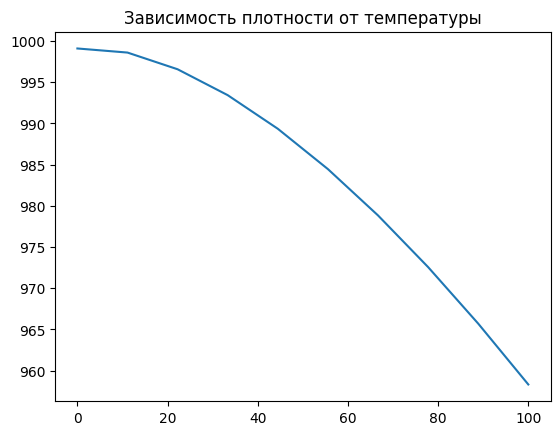

In [161]:
# построения графика функции зависимости плотности воды от температуры
x = np.linspace(0, 100, 10)                          # задание массива значений для построения графика
plt.plot(x, [calc_rho_w(0, t+273) for t in x])
plt.title('Зависимость плотности от температуры')
plt.show()

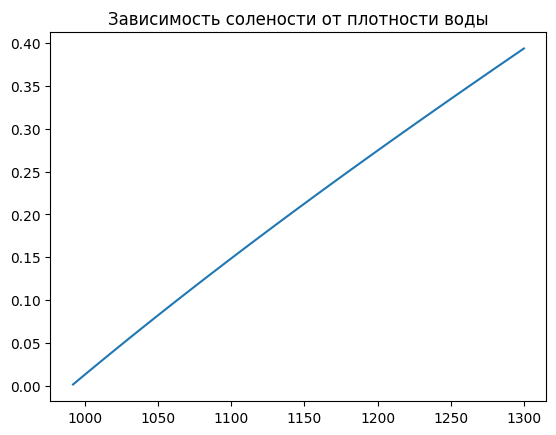

In [162]:
x = np.linspace(992, 1300, 50)                          # задание массива значений для построения графика
plt.plot(x, [calc_ws(gamma_wat/1000) for gamma_wat in x])
plt.title('Зависимость солености от плотности воды')
plt.show()

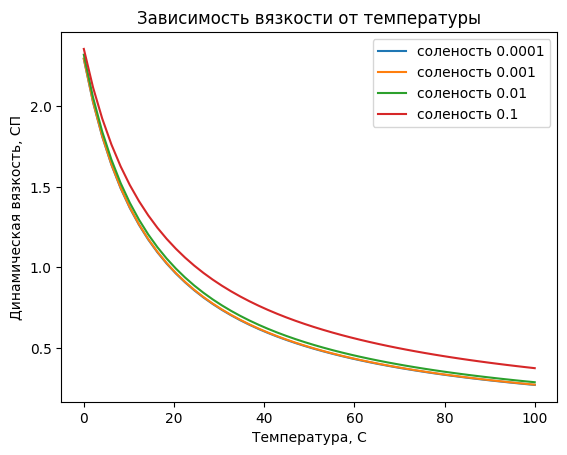

In [163]:
x = np.linspace(0, 100, 50)
plt.plot(x, [calc_mu_w(0.0001, t+273, 1*101325) for t in x], label = "соленость 0.0001")
plt.plot(x, [calc_mu_w(0.001, t+273, 1*101325) for t in x], label = "соленость 0.001")
plt.plot(x, [calc_mu_w(0.01, t+273, 1*101325) for t in x], label = "соленость 0.01")
plt.plot(x, [calc_mu_w(0.1, t+273, 1*101325) for t in x], label = "соленость 0.1")
plt.title('Зависимость вязкости от температуры')
plt.xlabel("Температура, С")
plt.ylabel("Динамическая вязкость, СП")
plt.legend()
plt.show()

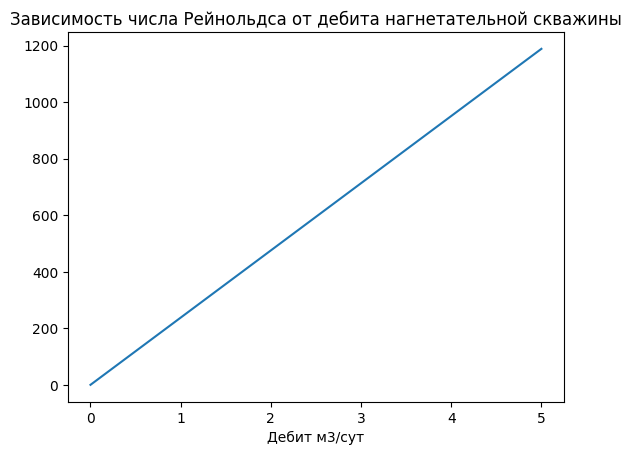

In [164]:
x = np.linspace(0, 5, 50)
plt.plot(x, [calc_n_re(rho_w=1000, q_ms=t/86400, mu_w=1, d_tub=0.062) for t in x])
plt.title('Зависимость числа Рейнольдса от дебита нагнетательной скважины')
plt.xlabel("Дебит м3/сут")
plt.show()

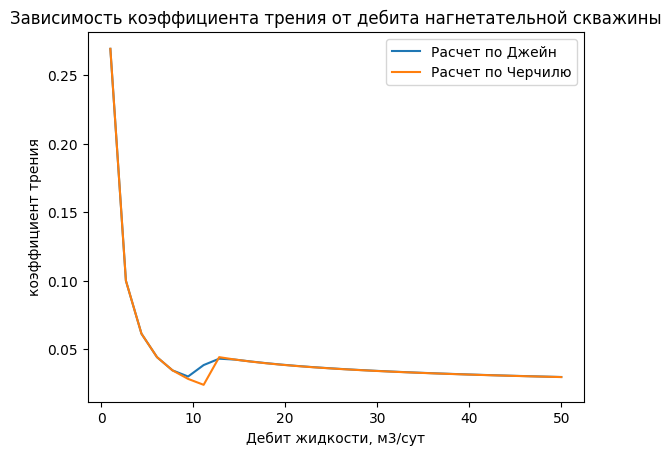

In [165]:
x = np.linspace(1, 50, 30)


n_re_list = [calc_n_re(rho_w=1000, q_ms=t/86400, mu_w=1, d_tub=0.062) for t in x]

plt.plot(x, [calc_ff_churchill(t, 0.0001, 0.62) for t in n_re_list], label ="Расчет по Джейн")
plt.plot(x, [calc_ff_jain(t, 0.0001, 0.62) for t in n_re_list], label ="Расчет по Черчилю")
plt.title('Зависимость коэффициента трения от дебита нагнетательной скважины')
plt.xlabel("Дебит жидкости, м3/сут")
plt.ylabel("коэффициент трения")
plt.legend()
plt.show()

На графике зависимости коэффициента трения Муди показаны расчеты выполненные с использованием корреляций Джейна и Черчиля. Видно что корреляции хорошо совпадают друг с другом. Корреляция Черчиля описывает и ламинарный и турбулентный режимы работы

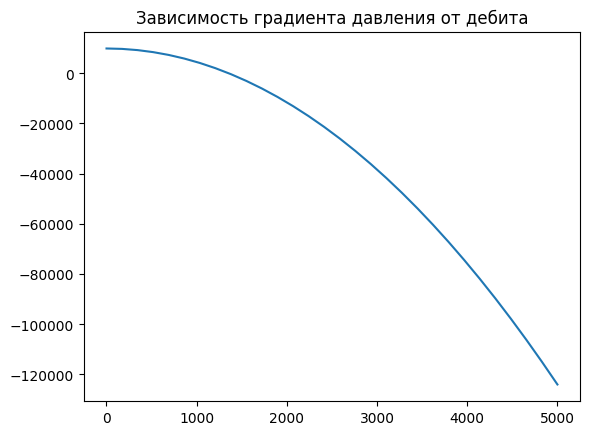

In [166]:
x = np.linspace(1, 5000, 30)
plt.plot(x, [calc_dp_dl(rho_w=1000, mu_w=1, angle=90, q_ms=t/86400, d_tub=0.062, roughness=0.001) for t in x])
plt.title('Зависимость градиента давления от дебита')
plt.show()

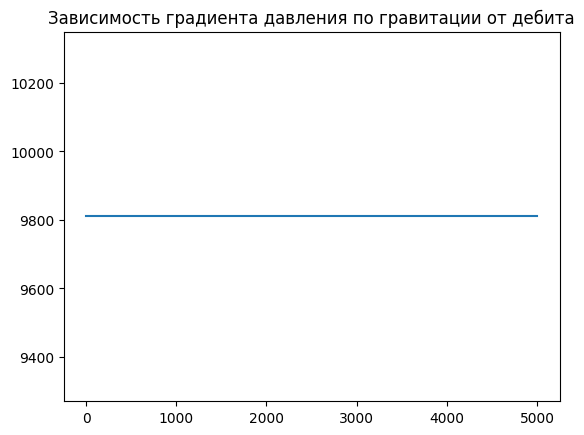

In [167]:
x = np.linspace(1, 5000, 30)
plt.plot(x, [calc_dp_dl_grav(rho_w=1000, angle=90) for t in x])
plt.title('Зависимость градиента давления по гравитации от дебита')
plt.show()

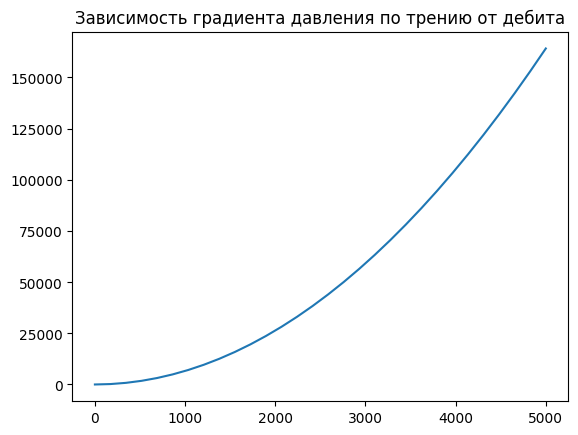

In [168]:
x = np.linspace(1, 5000, 30)
plt.plot(x, [calc_dp_dl_fric(rho_w=1000, mu_w=1, q_ms=t/86400, d_tub=0.062, roughness=0.001) for t in x])
plt.title('Зависимость градиента давления по трению от дебита')
plt.show()

# Расчет распределения давления 
Для расчета необходимо задать исходные данные и перезапустить расчет

Решение уравнения на распределение давления и температуры в стволе скважины. Решается система двух уравнений вида

$$ \frac{dP}{dL} = \frac{1}{10^{-5}} \left [  \rho g  \cos \alpha  - 0.815 \frac{f \rho}{d^5} q ^ 2  \right ]  $$

$$ \frac{dT}{dL} = geograd $$

Граничные условия задаются на устье скважины


In [169]:
def __integr_func(
        h: float,
        pt: tuple,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> tuple:
    """
    Функция для интегрирования трубы

    :param h: текущая глубина, м
    :param pt: текущее давление, Па и текущая температура, К
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: градиенты давления, Па/м и температуры, К/м
    """
    return calc_dp_dl(
        calc_rho_w(calc_ws(gamma_wat), pt[1]),
        calc_mu_w(calc_ws(gamma_wat), pt[1], pt[0]), 
        angle, q_ms, d_tub, roughness), temp_grad


def calc_pipe(
        p_wh: float,
        t_wh: float,
        h0: float,
        md_vdp: float,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> tuple:
    """
    Функция для расчета давления в трубе

    :param p_wh: буферное давление, Па
    :param t_wh: температура жидкости у буферной задвижки, К
    :param h0: начальная глубина, м
    :param md_vdp: глубина верхних дыр перфорации, м
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: давление, Па и температура, K, глубины
    """ 
    number_of_steps = 1000
    step = (md_vdp - h0) / number_of_steps

    P = []
    T = []

    P.append(p_wh)
    T.append(t_wh)
    
    for h in np.linspace(h0, md_vdp, number_of_steps):
        grad_p, grad_t = __integr_func(h, (P[-1], P[-1]), temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)
        P.append(grad_p * step + P[-1])
        T.append(grad_t * step + T[-1])

    return P, T

def calc_p_wf(
        p_wh: float,
        t_wh: float,
        h0: float,
        md_vdp: float,
        temp_grad: float,
        gamma_wat: float,
        angle: float,
        q_ms: float,
        d_tub: float,
        roughness: float
) -> float:
    """
    Функция для расчета давления на забое скважины

    :param p_wh: буферное давление, Па
    :param t_wh: температура жидкости у буферной задвижки, К
    :param h0: начальная глубина, м
    :param md_vdp: глубина верхних дыр перфорации, м
    :param temp_grad: геотермический градиент, К/м * (1e-2)
    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.
    :param angle: угол наклона скважины к горизонтали, градусы
    :param q_ms: дебит жидкости, м3/с
    :param d_tub: диаметр НКТ, м
    :param roughness: шероховатость стен трубы, м

    :return: давление на забое скважины, Па
    """
    ...

    p = calc_pipe(p_wh, t_wh, h0, md_vdp, temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)[0]

    return p[-1]

In [170]:
gamma_water = data['gamma_water'][0]
H = data['md_vdp'][0]
d_tub = data['d_tub'][0]
angle = data['angle'][0]
roughness = data['roughness'][0]
p_wh = data['p_wh'][0] * 101325
t_wh = data['t_wh'][0] + 273
temp_grad = data['temp_grad'][0]

In [171]:
Q = []
Pressure = []
h0 = 0

for q in range(0, 400, 10):
    Q.append(q)
    p = calc_p_wf(p_wh, t_wh, h0, H, temp_grad, gamma_water, angle, q / 86400, d_tub, roughness)
    Pressure.append(p / 101325) 

results = {'q_liq': list(Q), 'p_wf': list(Pressure)}

with open(r'output.json', 'w') as file:
    json.dump(results, file, indent=7)

## График

In [185]:
Q_pascal = []

for qi in Q:
    Q_pascal.append(qi * 101325)

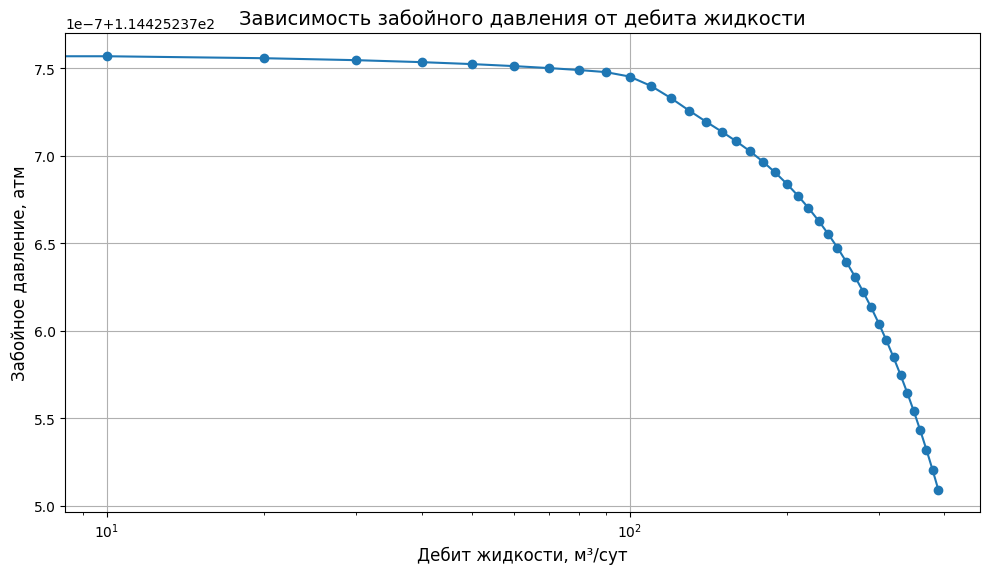

In [186]:
plt.figure(figsize=(10, 6))  # Увеличиваем размер графика

plt.semilogx(Q, Pressure, marker='o', linestyle='-') # логарифмическая шкала по оси Х

plt.xlabel("Дебит жидкости, м³/сут", fontsize=12)
plt.ylabel("Забойное давление, атм", fontsize=12)
plt.title("Зависимость забойного давления от дебита жидкости", fontsize=14)
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  # Автоматически настраивает расположение элементов графика, чтобы избежать перекрытия
plt.show()